# Agrupamento com Dados Agregados por Customer_ID

Neste notebook, o foco foi reduzir a quantidade de dados para facilitar o agrupamento e análise. Os dados foram agregados por *Customer_ID*, calculando a média das variáveis numéricas para cada cliente. Além disso, a redução de dimensionalidade com PCA foi aplicada novamente, utilizando 2 e 5 componentes principais.

Os melhores resultados foram obtidos com 2 componentes principais, onde o *silhouette score* alcançou 0.38. Embora o número de registros tenha sido reduzido, os agrupamentos não superaram a clareza e os insights obtidos no notebook anterior com os dados completos. A análise mostrou que a perda de granularidade dos dados pode prejudicar a performance do agrupamento, mesmo quando se aplica a redução de dimensionalidade.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Carregando os dados

In [2]:
df1 = pd.read_csv ('~/Documents/banking-customer-clustering/bank_data.csv')
df1.head()

,Branch_ID,City,Region,Firm_Revenue,Expenses,Profit_Margin
0,1000,Solapur,East,422443.0,346471,56.31
1,1001,Mumbai,North,211155.0,216256,79.53
2,1002,Nashik,West,985006.0,71777,55.31
3,1003,Solapur,North,55113.0,253655,2.57
4,1004,Nagpur,West,282701.0,148194,-14.10


In [3]:
df2 = pd.read_csv ('~/Documents/banking-customer-clustering/customer_data.csv')
df2.head()

,Customer_ID,Age,Customer_Type,City,Region,Bank_Name,Branch_ID
0,200000,56.0,Employee,Pune,North,HDFC Bank,1350
1,200001,69.0,NaN,Kolhapur,East,HDFC Bank,1648
2,200002,46.0,Business,Pune,West,HDFC Bank,1798
3,200003,32.0,Individual,Pune,West,HDFC Bank,1900
4,200004,NaN,Business,Kolhapur,East,HDFC Bank,1227


In [4]:
df3 = pd.read_csv ('~/Documents/banking-customer-clustering/transaction_data.csv')
df3.head()

,Transaction_ID,Customer_ID,Account_Type,Total_Balance,Transaction_Amount,Investment_Amount,Investment_Type,Transaction_Date
0,300000,209689,Business,69339,4794.0,42580,Fixed Deposit,2024-12-08
1,300001,206124,Business,12825,3500.0,46605,Fixed Deposit,2022-09-09
2,300002,207501,Current,67753,2401.0,17027,Fixed Deposit,2022-04-28
3,300003,208675,Savings,67061,2952.0,3054,Fixed Deposit,2023-05-22
4,300004,204923,Business,8566,1025.0,44937,Fixed Deposit,2023-04-05


In [5]:
bank_data = pd.merge(df1, df2, on= 'Branch_ID', how='inner')

In [6]:
df = pd.merge(bank_data, df3, on='Customer_ID', how='inner')

In [7]:
df.head()

,Branch_ID,City_x,Region_x,Firm_Revenue,Expenses,Profit_Margin,Customer_ID,Age,Customer_Type,City_y,Region_y,Bank_Name,Transaction_ID,Account_Type,Total_Balance,Transaction_Amount,Investment_Amount,Investment_Type,Transaction_Date
0,1000,Solapur,East,422443.0,346471,56.31,204700,54.0,Individual,Kolhapur,East,HDFC Bank,304833,Current,57622,4676.0,11260,Fixed Deposit,2024-04-05
1,1000,Solapur,East,422443.0,346471,56.31,204955,51.0,Business,Solapur,South,HDFC Bank,300574,Business,37337,1121.0,27750,Fixed Deposit,2024-05-29
2,1000,Solapur,East,422443.0,346471,56.31,205772,57.0,Individual,Nashik,West,HDFC Bank,304051,Current,26773,2924.0,9480,Recurring Deposit,2025-02-14
3,1000,Solapur,East,422443.0,346471,56.31,205772,57.0,Individual,Nashik,West,HDFC Bank,307451,Current,31080,780.0,8956,Fixed Deposit,2022-11-07
4,1000,Solapur,East,422443.0,346471,56.31,205772,57.0,Individual,Nashik,West,HDFC Bank,309364,Business,61386,3988.0,19907,Mutual Fund,2023-05-03


# Análise exploratória

In [8]:
df.shape

(10000, 19)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Branch_ID           10000 non-null  int64  
 1   City_x              10000 non-null  object 
 2   Region_x            10000 non-null  object 
 3   Firm_Revenue        9433 non-null   float64
 4   Expenses            10000 non-null  int64  
 5   Profit_Margin       10000 non-null  float64
 6   Customer_ID         10000 non-null  int64  
 7   Age                 9499 non-null   float64
 8   Customer_Type       9495 non-null   object 
 9   City_y              9496 non-null   object 
 10  Region_y            10000 non-null  object 
 11  Bank_Name           10000 non-null  object 
 12  Transaction_ID      10000 non-null  int64  
 13  Account_Type        10000 non-null  object 
 14  Total_Balance       10000 non-null  int64  
 15  Transaction_Amount  10000 non-null  float64
 16  Inves

In [10]:
df.describe()

,Branch_ID,Firm_Revenue,Expenses,Profit_Margin,Customer_ID,Age,Transaction_ID,Total_Balance,Transaction_Amount,Investment_Amount
count,10000.000000,9433.000000,10000.000000,10000.000000,10000.000000,9499.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1496.861600,507974.155412,266679.728400,24.036064,205028.182600,49.086535,304999.50000,50221.505800,2542.708056,25550.248400
std,290.492938,277581.933403,139731.304605,42.370806,2909.008139,18.104528,2886.89568,28540.392011,1432.677420,14108.052078
min,1000.000000,51241.000000,20520.000000,-49.500000,200000.000000,18.000000,300000.00000,1003.000000,51.613952,1001.000000
25%,1241.000000,255785.000000,148194.000000,-12.800000,202498.750000,34.000000,302499.75000,25132.000000,1310.000000,13381.000000
50%,1498.000000,510682.000000,269692.000000,22.360000,205060.000000,49.000000,304999.50000,50326.000000,2538.500000,25708.500000
75%,1748.000000,740370.000000,394440.000000,61.340000,207561.000000,65.000000,307499.25000,74914.500000,3746.250000,37731.000000
max,1999.000000,999975.000000,499568.000000,99.970000,209999.000000,79.000000,309999.00000,99993.000000,7046.296441,49998.000000


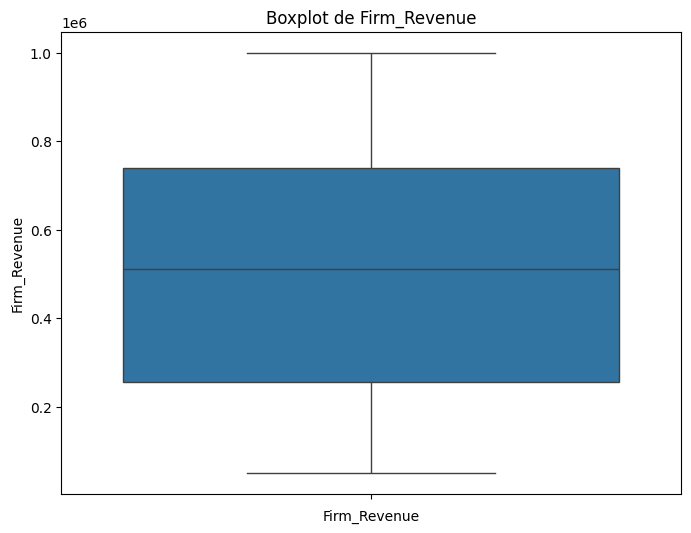

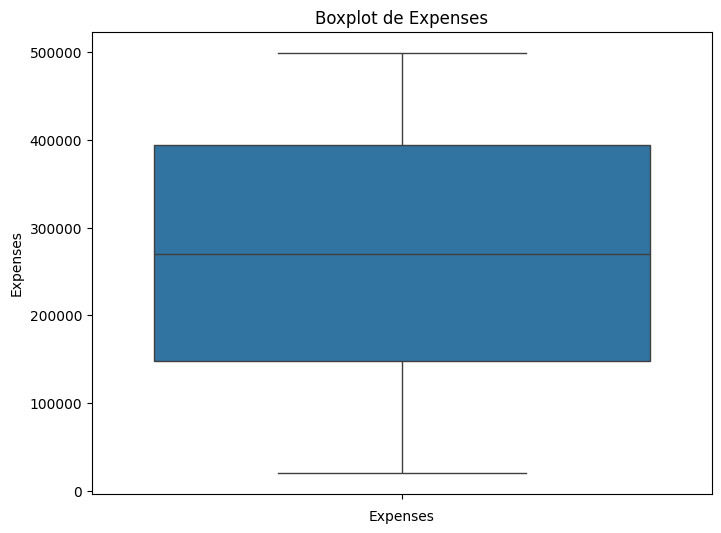

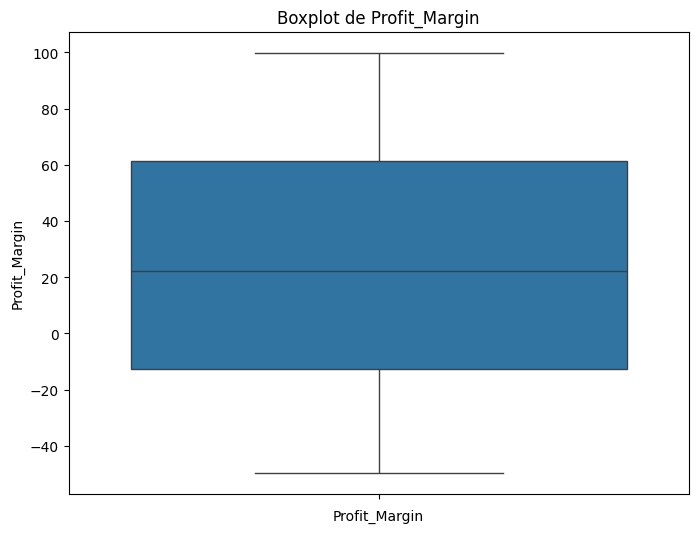

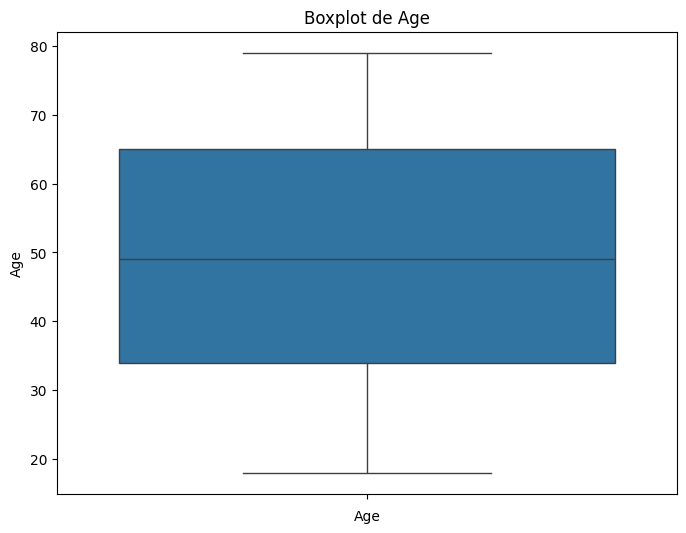

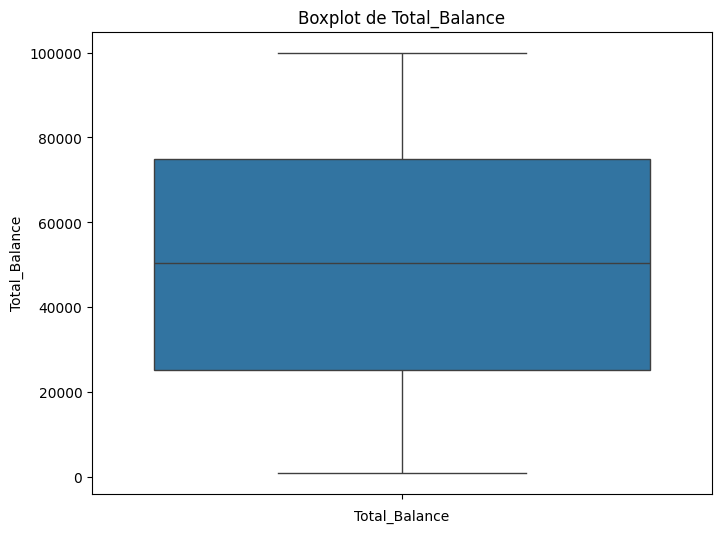

In [11]:
# Listando as colunas numéricas para gerar os boxplots
numerical_columns = ['Firm_Revenue', 'Expenses', 'Profit_Margin', 'Age', 'Total_Balance']

# Gerando boxplots para cada variável
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()


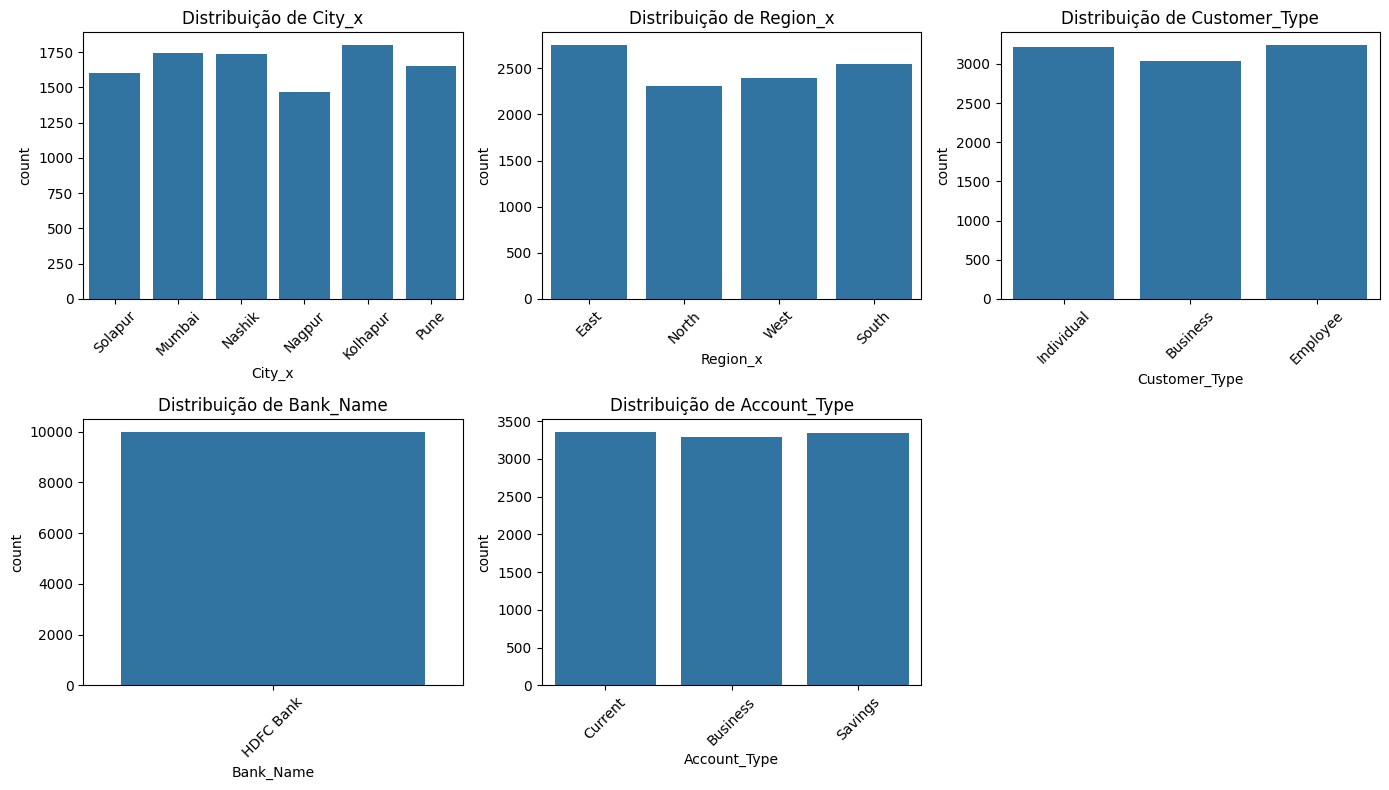

In [12]:
# Gráfico de barras para variáveis categóricas
categorical_columns = ['City_x', 'Region_x', 'Customer_Type', 'Bank_Name', 'Account_Type']

plt.figure(figsize=(14, 8))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=column)
    plt.title(f'Distribuição de {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [13]:
# Exemplo de agregação
df_grouped = df.groupby(['City_x', 'Region_x']).agg({
    'Firm_Revenue': 'mean',
    'Expenses': 'mean',
    'Profit_Margin': 'mean',
    'Total_Balance': 'mean',
    'Transaction_Amount': 'sum'
}).reset_index()

# Verificando a agregação
df_grouped.head()


,City_x,Region_x,Firm_Revenue,Expenses,Profit_Margin,Total_Balance,Transaction_Amount
0,Kolhapur,East,454432.109726,295705.084388,22.091013,51239.464135,1.232187e+06
1,Kolhapur,North,477233.659306,254021.919897,19.004057,50182.981912,1.019722e+06
2,Kolhapur,South,488810.317673,281086.844262,24.363750,49743.456967,1.231386e+06
3,Kolhapur,West,481383.094907,252314.643016,17.622816,50411.487805,1.141913e+06
4,Mumbai,East,455938.596581,219449.933775,23.354735,50995.312914,1.542507e+06


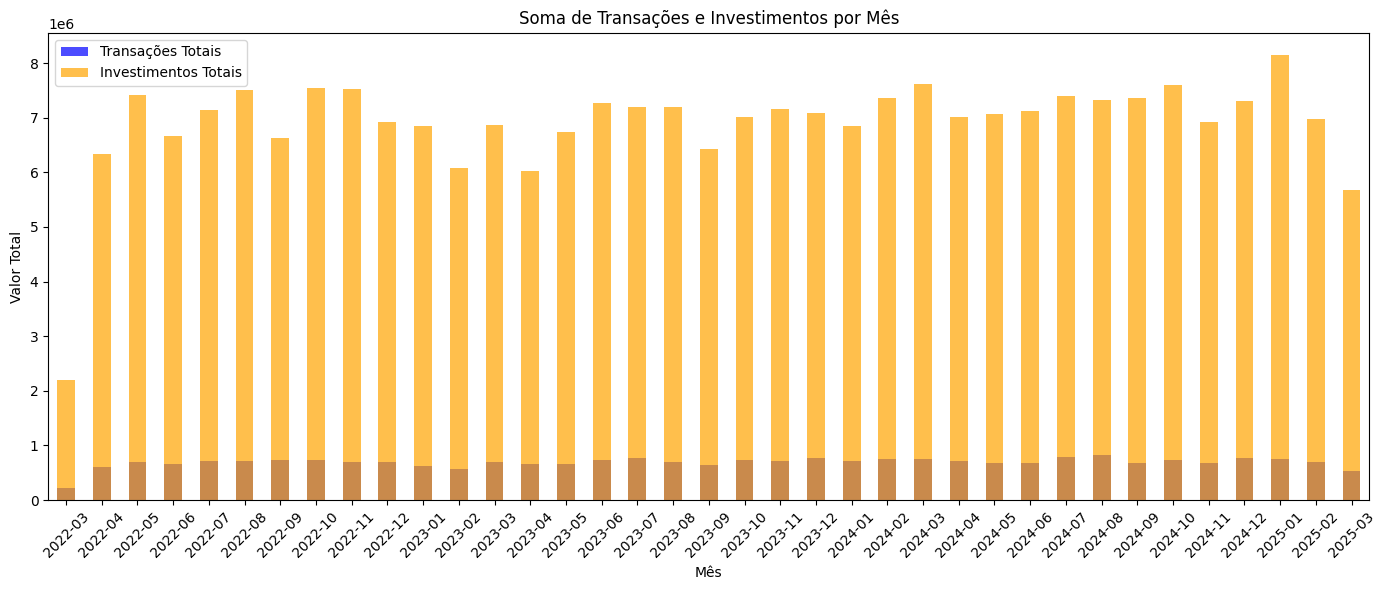

In [14]:
# Adicionando uma coluna 'Ano-Mês'
df['Month'] = pd.to_datetime(df['Transaction_Date']).dt.to_period('M')

# Agrupando por 'Month' e somando os valores de transações e investimentos
df_monthly = df.groupby('Month')[['Transaction_Amount', 'Investment_Amount']].sum()

# Plotando a soma das transações por mês
plt.figure(figsize=(14, 6))
df_monthly['Transaction_Amount'].plot(kind='bar', color='blue', alpha=0.7, label='Transações Totais')
df_monthly['Investment_Amount'].plot(kind='bar', color='orange', alpha=0.7, label='Investimentos Totais')

plt.title('Soma de Transações e Investimentos por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Total')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


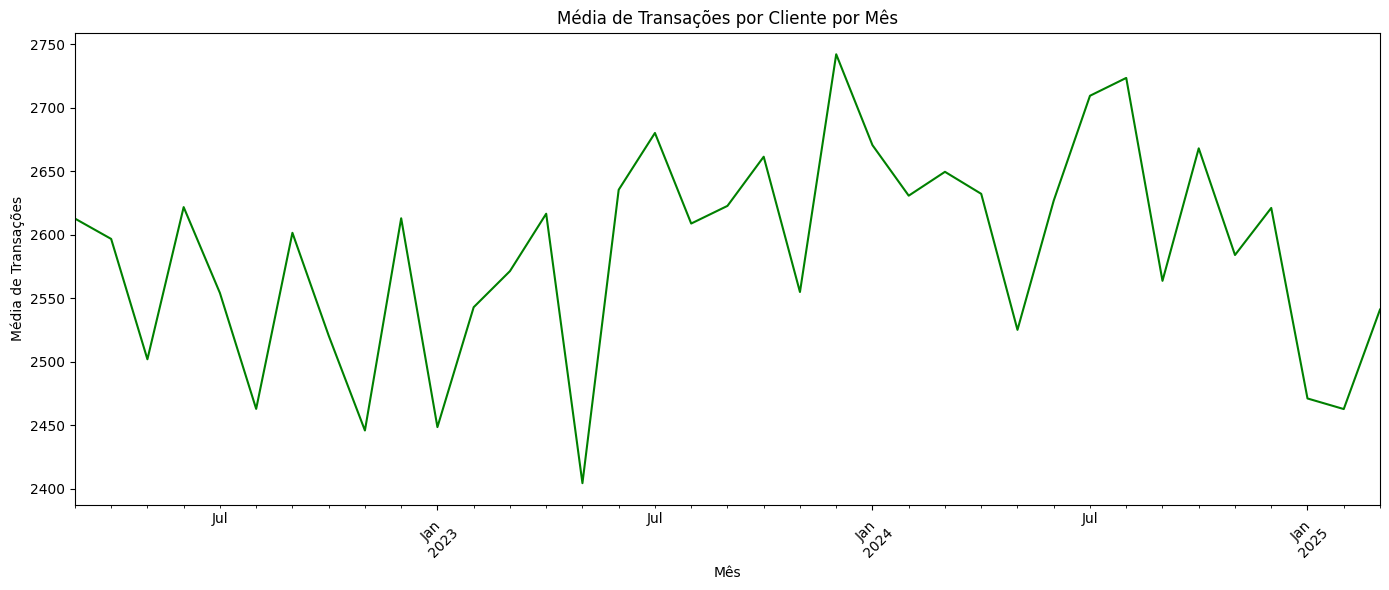

In [15]:
# Agrupando por 'Month' e 'Customer_ID' para obter a média de transações
df_customer_monthly = df.groupby(['Month', 'Customer_ID'])['Transaction_Amount'].sum().reset_index()

# Calculando a média das transações por mês
df_monthly_avg = df_customer_monthly.groupby('Month')['Transaction_Amount'].mean()

# Plotando a média de transações por cliente por mês
plt.figure(figsize=(14, 6))
df_monthly_avg.plot(kind='line', color='green')
plt.title('Média de Transações por Cliente por Mês')
plt.xlabel('Mês')
plt.ylabel('Média de Transações')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Dataprep

In [16]:
# Imputação dados numéricos (média)
imputer = SimpleImputer(strategy='mean')  
df['Firm_Revenue'] = imputer.fit_transform(df[['Firm_Revenue']])
df['Age'] = imputer.fit_transform(df[['Age']])

In [17]:
df.shape

(10000, 20)

In [18]:
# Imputação dados numéricos (moda)
# Lista das colunas categóricas
cat_cols = ['Customer_Type', 'City_y', 'Investment_Type', 'City_x', 'Region_x', 'Bank_Name', 'Account_Type']

# Imputador com a moda
imputer = SimpleImputer(strategy='most_frequent')

# Aplicando a imputação coluna a coluna
for col in cat_cols:
    df[col] = imputer.fit_transform(df[[col]])[:, 0]



In [19]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')

In [20]:
df['transaction_dayofweek'] = df['Transaction_Date'].dt.dayofweek
df['transaction_day'] = df['Transaction_Date'].dt.day
df['is_weekend'] = df['transaction_dayofweek'].isin([5, 6]).astype(int)
df['days_since_first_tx'] = (df['Transaction_Date'] - df['Transaction_Date'].min()).dt.days

In [24]:
# Codificar variáveis categóricas:
df_encoded = pd.get_dummies(df, columns=['Customer_Type', 'Account_Type', 'Investment_Type', 'City_x', 'Region_x', 'City_y', 'Region_y', 'Bank_Name' ], drop_first=True)

In [25]:
df_encoded=df_encoded.groupby('Customer_ID').mean().reset_index()
df_encoded.shape

(6335, 38)

In [26]:
df_encoded = df_encoded.drop(columns=['Transaction_Date', 'Month', 'Customer_ID'])

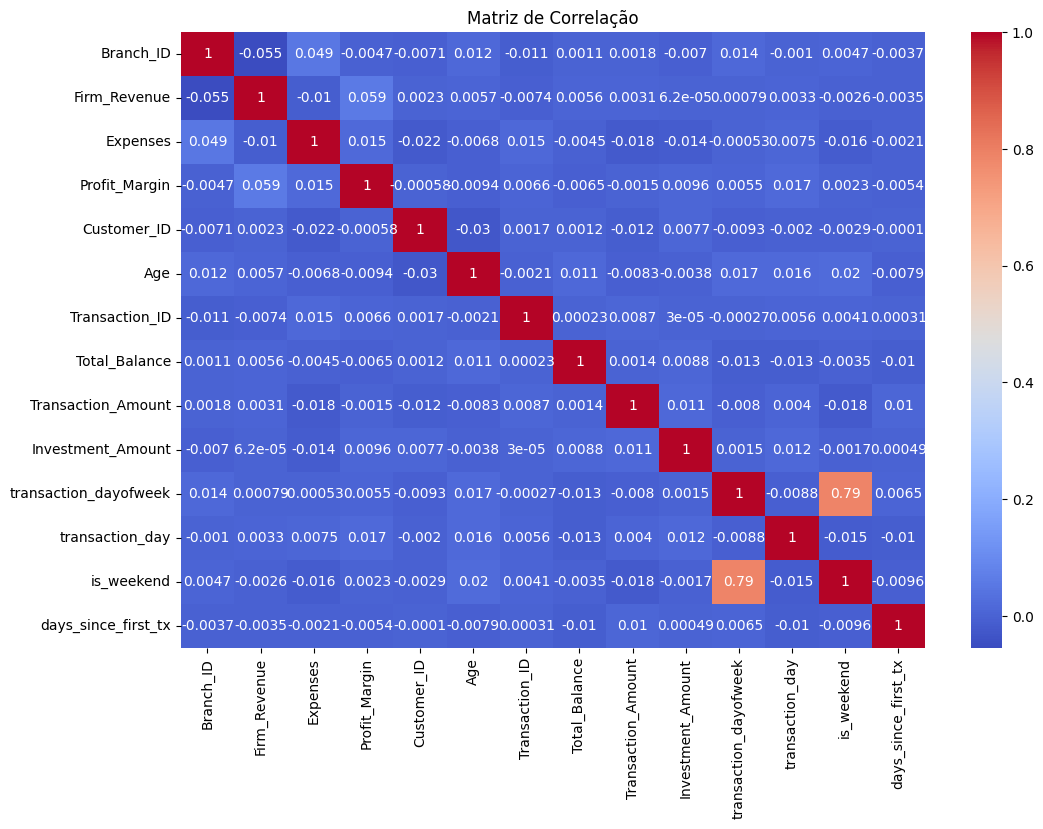

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

Treinamento com todas as Features

In [28]:
# Padronizar os dados numéricos:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

In [29]:
# 2. Rode o PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

In [30]:
loadings = pd.DataFrame(pca.components_, columns=df_encoded.columns)

In [31]:
print("Componente 1:")
print(loadings.iloc[0].sort_values(ascending=False))

Componente 1:
is_weekend                           0.699672
transaction_dayofweek                0.699341
Region_y_North                       0.063388
Age                                  0.046860
Account_Type_Savings                 0.034318
Investment_Type_Mutual Fund          0.027481
Region_x_West                        0.026673
City_y_Nashik                        0.018167
City_x_Nashik                        0.017272
Branch_ID                            0.009107
City_x_Mumbai                        0.008131
City_x_Nagpur                        0.004726
City_y_Pune                          0.002437
City_x_Solapur                       0.000257
City_y_Nagpur                       -0.000166
Investment_Amount                   -0.000277
days_since_first_tx                 -0.000609
Customer_Type_Individual            -0.001308
City_y_Mumbai                       -0.003075
Customer_Type_Employee              -0.003492
Region_y_South                      -0.005169
Region_x_North      

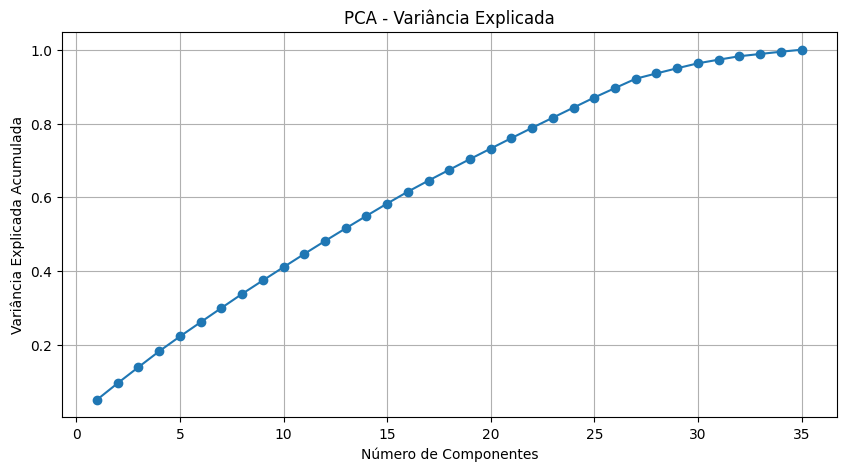

In [32]:
pca = PCA()
pca.fit(X_scaled)  # scaled_data = seus dados normalizados

# Variância explicada por componente
plt.figure(figsize=(10,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.grid(True)
plt.show()

In [33]:
X_scaled.shape

(6335, 35)

# Agrupamento kmeans

In [34]:
# Mantendo só os 24 primeiros componentes
X_pca = pca.transform(X_scaled)[:, :2]

In [35]:
inertias = []
silhouette_scores = []
k_range = range(2, 20, 2)

In [36]:

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    # Armazena a inércia
    inertias.append(kmeans.inertia_)
    
    # Armazena o silhouette score
    silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

c:\Users\bianc\Documents\Itau-Analise-de-Credito\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\bianc\Documents\Itau-Analise-de-Credito\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.p

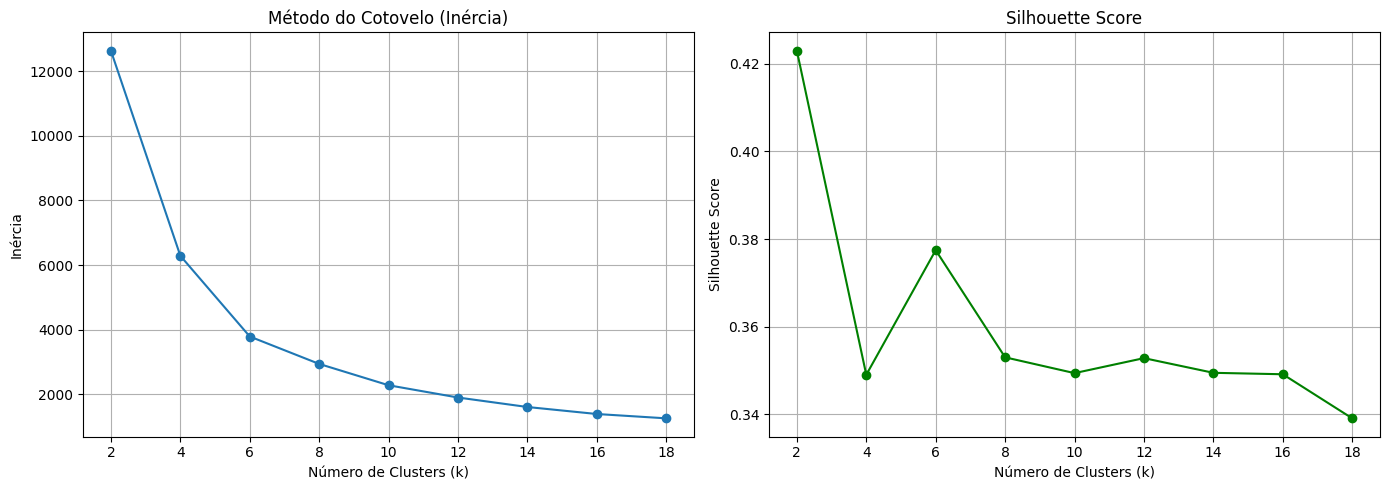

In [37]:
import matplotlib.pyplot as plt

# Criando os subplots primeiro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Cotovelo
ax1.plot(k_range, inertias, marker='o')
ax1.set_title('Método do Cotovelo (Inércia)')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia')
ax1.grid(True)

# Gráfico do Silhouette
ax2.plot(k_range, silhouette_scores, marker='o', color='green')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

# Ajustando o layout para não sobrepor os gráficos
plt.tight_layout()

# Exibindo os gráficos
plt.show()


# Agrupamento kmeans

In [38]:
# Mantendo só os 24 primeiros componentes
X_pca2 = pca.transform(X_scaled)[:, :5]

In [39]:
inertias2 = []
silhouette_scores2 = []
k_range2 = range(2, 20, 2)

In [40]:

for k in k_range2:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca2)
    
    # Armazena a inércia
    inertias2.append(kmeans.inertia_)
    
    # Armazena o silhouette score
    silhouette_scores2.append(silhouette_score(X_pca2, cluster_labels))

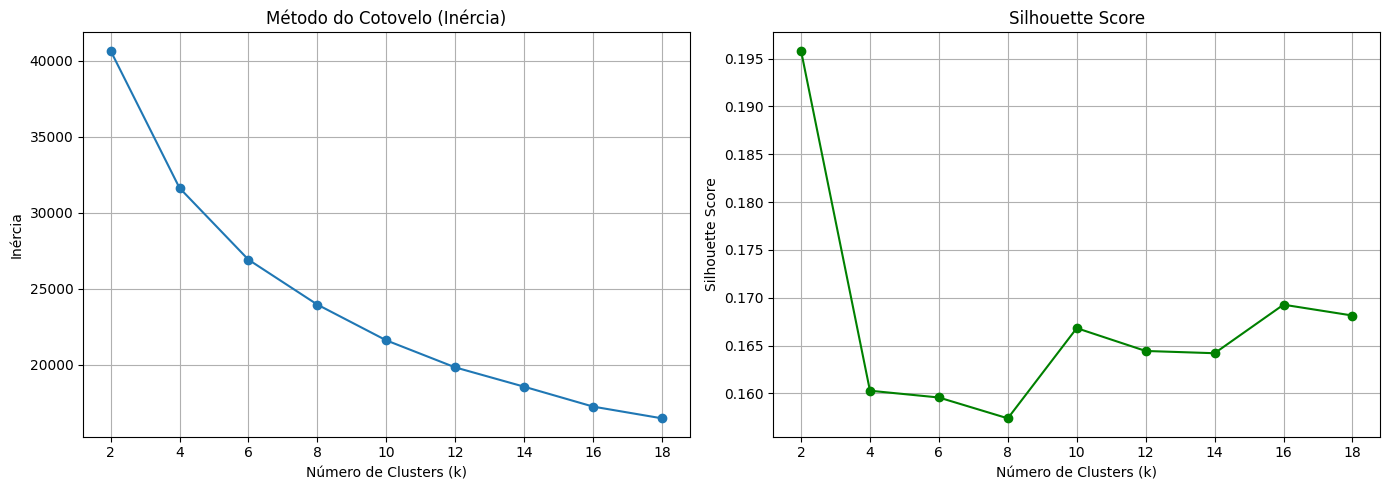

In [41]:
import matplotlib.pyplot as plt

# Criando os subplots primeiro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Cotovelo
ax1.plot(k_range2, inertias2, marker='o')
ax1.set_title('Método do Cotovelo (Inércia)')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia')
ax1.grid(True)

# Gráfico do Silhouette
ax2.plot(k_range2, silhouette_scores2, marker='o', color='green')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

# Ajustando o layout para não sobrepor os gráficos
plt.tight_layout()

# Exibindo os gráficos
plt.show()
